Delineation map

Notebook based on version from Cindy de Vries @ https://github.com/CindyvdVries/Sentinel_Data 
Simple discriminant analysis 


In [26]:
#  Some libraries
import os
import operator
import getpass

import numpy as np
import scipy.stats
import gdal
from gdalconst import * 
import rasterio

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# Download data from the sentinel hub. Get an account 
# Note that the $ in the url needs to be escaped
url = "https://scihub.esa.int/dhus/odata/v1/Products('96aa4cf3-3913-4e01-a876-29ecad175336')/\$value"
password = getpass.getpass('password')
!wget "$url" --http-user=crisis_download --http-password=$password --content-disposition

password········
--2015-10-27 20:14:11--  https://scihub.esa.int/dhus/odata/v1/Products('96aa4cf3-3913-4e01-a876-29ecad175336')/$value
Resolving scihub.esa.int (scihub.esa.int)... 131.176.236.13
Connecting to scihub.esa.int (scihub.esa.int)|131.176.236.13|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="OData service"
Connecting to scihub.esa.int (scihub.esa.int)|131.176.236.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1039730218 (992M) [application/octet-stream]
Saving to: ‘S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.zip’

S1A_IW_GRDH_1SDV_20 100%[=====================>] 991.56M  1.26MB/s   in 15m 51s

2015-10-27 20:30:02 (1.04 MB/s) - ‘S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.zip’ saved [1039730218/1039730218]



In [23]:
# Clear the existing temp tiff files
!rm -f waterVH.tiff
!rm -f landVH.tiff
!rm -f VH.tiff

# Unzip the tiff file
!unzip S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.zip

# the files
vhfile = 'S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.SAFE/measurement/s1a-iw-grd-vh-20151008t055819-20151008t055844-008057-00b493-002.tiff'
vvfile = 'S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.SAFE/measurement/s1a-iw-grd-vv-20151008t055819-20151008t055844-008057-00b493-001.tiff'

# Create temp tiff file with a bounding box
!gdalwarp -t_srs EPSG:4326 -te 2 51.05 4.3 51.44 $vhfile VH.tiff
!gdalwarp -t_srs EPSG:4326 -te 2 51.3 3 51.44 $vhfile waterVH.tiff
!gdalwarp -t_srs EPSG:4326 -te 4 51.0 5 51.1 $vhfile landVH.tiff


Archive:  S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.zip
   creating: S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.SAFE/
  inflating: S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.SAFE/S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.SAFE-report-20151008T093116.pdf  
   creating: S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.SAFE/support/
  inflating: S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.SAFE/support/s1-level-1-calibration.xsd  
  inflating: S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.SAFE/support/s1-level-1-product.xsd  
  inflating: S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.SAFE/support/s1-object-types.xsd  
  inflating: S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B493_241C.SAFE/support/s1-level-1-noise.xsd  
  inflating: S1A_IW_GRDH_1SDV_20151008T055819_20151008T055844_008057_00B4

In [28]:
# Water colorbands
variables = {}
with rasterio.drivers():
    with rasterio.open('waterVH.tiff') as water:
        variables['wet'] = np.log10(water.read_band(1))
    with rasterio.open('landVH.tiff') as land:
        variables['dry'] = np.log10(land.read_band(1))
    with rasterio.open('VH.tiff') as vh:
        variables['vh'] = np.log10(vh.read_band(1))


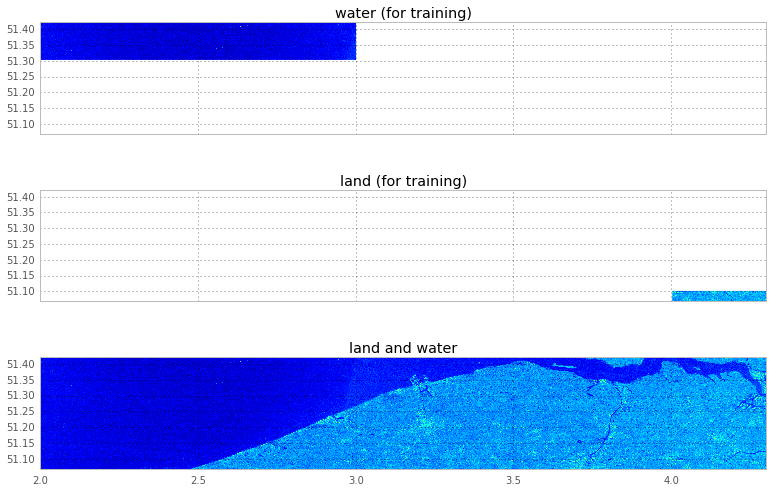

In [50]:
# visualizations of parts of the tiffs
fig, axes = plt.subplots(3,1, sharex=True, sharey=True, figsize=(13,8))
axes[0].imshow(variables['wet'], vmin =1, vmax = 4.5, extent=(2, 3, 51.3, 51.44))
axes[0].set_title('water (for training)')

axes[1].imshow(variables['dry'], vmin =1, vmax = 4.5, extent=( 4, 5, 51.0,  51.1))
axes[1].set_title('land (for training)')

axes[2].imshow(variables['vh'], vmin =1, vmax = 4.5,  extent=( 2, 4.3, 51.05, 51.44))
axes[2].set_title('land and water')


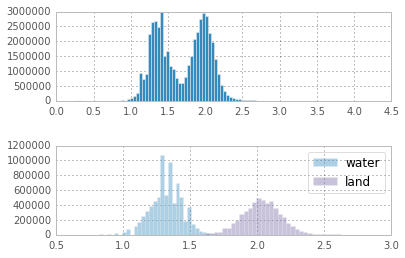

In [52]:
# Visualization of the distribution of the color band 
# Total distribution
fig, axes = plt.subplots(2, 1)
_ = axes[0].hist(variables['vh'].flat, bins=100)

# Distribution for a complete wet part and a complete dry part
_ = axes[1].hist(variables['wet'].flat, bins=100, label='water', alpha=0.4)
_ = axes[1].hist(variables['dry'].flat, bins=100, label='land', alpha=0.4)

axes[1].set_xlim(0.5, 3)
axes[1].legend()

In [77]:
# Fit the normal distributions to the wet and dry part
loc_wet, scale_wet = scipy.stats.norm.fit(variables['wet'])
loc_dry, scale_dry = scipy.stats.norm.fit(variables['dry'])

# compute a z score
z_wet = lambda value: (value - loc_wet)/scale_wet
z_dry = lambda value: (value - loc_dry)/scale_dry


# probability that a pixel is wet
cdf_wet = scipy.stats.norm.cdf(variables['vh'], loc_wet, scale_wet)
cdf_dry = scipy.stats.norm.cdf(variables['vh'], loc_dry, scale_dry)

# not really a probability (TODO: check what want here.)
p_wet = 1.0 - np.abs(cdf_wet - 0.5)*2.0
p_dry = 1.0 - np.abs(cdf_dry - 0.5)*2.0


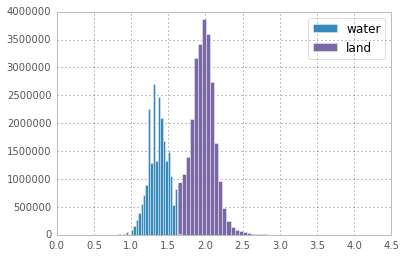

In [81]:
is_water = np.abs(z_wet(variables['vh'])) < np.abs(z_dry(variables['vh']))
_ = plt.hist(variables['vh'][is_water], label='water', bins = 40)
_ = plt.hist(variables['vh'][~is_water], label='land', bins =50)
plt.legend()


In [90]:
# generate a color image with blue for water and greenish for land
# bit of red
r = np.zeros_like(p_dry) + 0.1
g = p_dry
b = p_wet 
img = np.dstack([r, g, b])


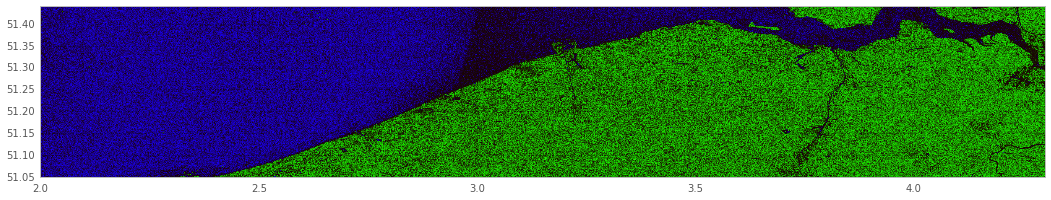

In [91]:
# plot the img
plt.subplots(figsize=(18,12))
plt.imshow(img[::2, ::2, :], extent=( 2, 4.3, 51.05, 51.44))

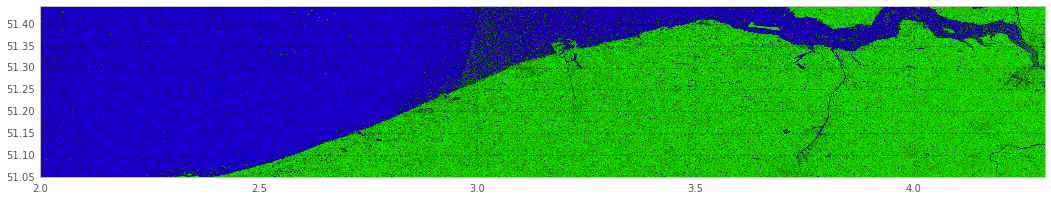

In [96]:
r = np.zeros_like(p_dry) + 0.1
# half binary/half probability for a bit stronger picture
g = 0.5*p_dry + 0.5*(np.abs(p_dry) >= np.abs(p_wet))
b = 0.5*p_wet + 0.5*(np.abs(p_wet) > np.abs(p_dry))
img = np.dstack([r, g, b])
plt.subplots(figsize=(18,12))
plt.imshow(img[::2, ::2, :], extent=( 2, 4.3, 51.05, 51.44))

This is just a simple algorithm that is fast and works reasonably (accuracy ~ 90%)
There are a lot of improvements possible:
- use more data (more areas used for training)
- use train/test/validate sets
- use more advanced model (better clustering)
- use more info (different polarizations, take into account angle of incidence)
- use modern workflow (oversegment, classify, subsegment, etc...)
